In [1]:
import kaggle
import os

In [2]:
#fetching the dataset
#200 values in test, 800 in train 
kaggle.api.authenticate()
local_path = './data_set'
if not os.path.isdir('data_set'):
    os.makedirs('data_set')
kaggle.api.dataset_download_files('dansbecker/hot-dog-not-hot-dog', path=local_path, unzip=True)

In [9]:
import cv2
from matplotlib import cm, pyplot as plt
import numpy as np
%matplotlib inline
def print_img(x):
    '''
    prints the image of a given digit
    '''
    plt.imshow(x)
    plt.axis("off")
    
    plt.show()

In [50]:
from sys import stdout
def sweep_dir(folder, recursive=True):
    '''
    sweep a given folder for all images, process and load them into a np dataset which gets returned
    '''
    dataset = None
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            print("loading file: "+folder+file, end='\r')
            stdout.flush()
            img = cv2.imread(folder+file) #loading in the image in color
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converting to rgb
            img = cv2.resize(img,(480, 480))           #reshaping to be 480 by 480 pixles
            if dataset is None:
                dataset = np.expand_dims(img,axis=0)
            else:
                dataset = np.vstack((dataset, np.expand_dims(img,axis=0)))
        elif os.path.isdir(folder+file) and recursive is True: #if this is a directory
            rec_set = sweep_dir(folder+file+'/')
            if dataset is None:
                dataset = rec_set
            else:
                dataset = np.vstack((dataset, rec_set))
    print("                                                                                             ", end='\r')
    return dataset
X_train = sweep_dir(local_path+'/')
print("Train size: ", X_train.shape)

Train size:  (998, 480, 480, 3)                                                              


In [54]:
y_train = np.zeros((X_train.shape[0]), dtype=bool)
y_train[:499] = True

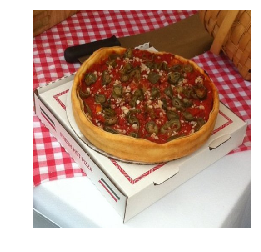

False


In [55]:
print_img(X_train[501])
print(y_train[501])

In [56]:
#shuffling the data
shuffle_perm = np.random.permutation((X_train.shape[0]))
X_train, y_train = X_train[shuffle_perm], y_train[shuffle_perm]

In [57]:
from sklearn.linear_model import SGDClassifier as sgdc
hot_not_hot = sgdc(random_state=42)
hot_not_hot.fit(X_train, y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

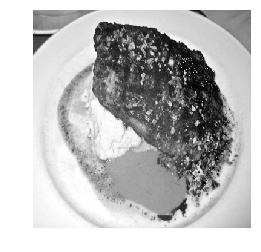

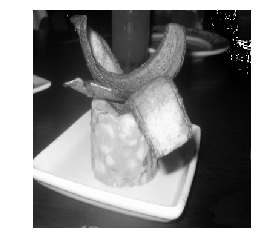

array([ True, False])

In [44]:
#a random_image
rand_val = np.random.randint(low=0,high=X_train.shape[0])
val_1 = X_train[rand_val]
print_img(val_1)

#a random second image
rand_val = np.random.randint(low=0,high=X_train.shape[0])
val_2 = X_train[rand_val]
print_img(val_2)

hot_not_hot.predict([val_1, val_2])

In [45]:
from sklearn.metrics import confusion_matrix #very confused
def get_scores(y_train, y_pred):
    '''
    y train - expected values
    y pred - model given values
    returns recall, precision, fscore
    '''
    confusion = confusion_matrix(y_train, y_pred)
    fp = confusion[0][1] # false_positive
    fn = confusion[1][0] #false_negative
    tp = confusion[1][1] #true_positive
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    fscore = 2/((1/precision)+(1/recall))
    return (precision, recall, fscore)

In [46]:
#measuring accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(hot_not_hot, X_train, y_train, cv=3)
np.unique(y_train_pred,return_counts=True)

(array([False,  True]), array([355, 443]))

In [47]:
precision, recall, fscore = get_scores(y_train, y_train_pred)
print("Precision (When claiming it sees a hot dog, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of dogs.\nF-score of:",fscore)

Precision (When claiming it sees a hot dog, is correct): 49.887133182844245 % of time.
Recall(Model catches): 55.388471177944865 % of dogs.
F-score of: 0.5249406175771972


In [48]:
y_train_decision = cross_val_predict(hot_not_hot, X_train, y_train, cv=3, method = "decision_function")
from sklearn.metrics import roc_auc_score
#perfect classifier area under true_positive_rate v false_positive_rate equals 1
roc_auc_score(y_train, y_train_decision)

0.5299150130966515

In [77]:
from sklearn.ensemble import RandomForestClassifier as rfc
forest_clf = rfc(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
y_forest_decision = y_prob_forest[:,1]

In [88]:
threshold = 0.3 #value between 0 and 1, interesting to see how precision and recall fluctuate when threshold changes
y_decision_threshold = y_forest_decision>threshold
np.unique((y_decision_threshold),return_counts=True)

(array([False,  True]), array([230, 768]))

In [89]:
precision, recall, fscore = get_scores(y_train, y_decision_threshold)
print("Precision (When claiming it sees a 4, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of fours.\nF-score of:",fscore)

Precision (When claiming it sees a 4, is correct): 54.427083333333336 % of time.
Recall(Model catches): 83.76753507014027 % of fours.
F-score of: 0.65982636148382


In [116]:
from sklearn.model_selection import RandomizedSearchCV as rscv
param_grid = {'n_estimators': [60], 'max_features': [10,12], 'n_jobs': [5], 'max_leaf_nodes':range(10,80,10)}
random_search = rscv(forest_clf, param_grid, cv=5, scoring = "f1")

In [117]:
#fitting the model
random_search.fit(X_train, y_decision_threshold)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [60], 'max_features': [10, 12], 'n_jobs': [5], 'max_leaf_nodes': range(10, 80, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [118]:
print("Acheaved score of:\t", random_search.best_score_)
print("With following paramaters:\t", random_search.best_params_)
print("The model:",random_search.best_estimator_)

Acheaved score of:	 0.8737839910711022
With following paramaters:	 {'n_jobs': 5, 'n_estimators': 60, 'max_leaf_nodes': 40, 'max_features': 12}
The model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=12, max_leaf_nodes=40,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=5, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [139]:
final_model = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=12, max_leaf_nodes=40,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=5, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
y_forest = cross_val_predict(final_model, X_train, y_train, cv=10)

In [140]:
precision, recall, fscore = get_scores(y_train, y_forest)
print("Precision (When claiming it sees a 4, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of fours.\nF-score of:",fscore)

Precision (When claiming it sees a 4, is correct): 63.39113680154143 % of time.
Recall(Model catches): 65.93186372745491 % of fours.
F-score of: 0.6463654223968566


In [143]:
final_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=12, max_leaf_nodes=40,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=5, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

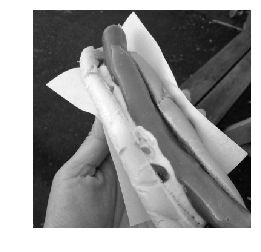

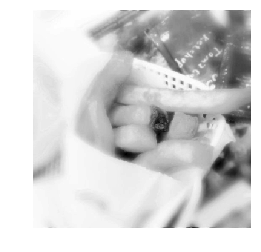

array([ True, False])

In [153]:
#a random_image
rand_val = np.random.randint(low=0,high=X_train.shape[0])
val_1 = X_train[rand_val]
print_img(val_1)

#a random second image
rand_val = np.random.randint(low=0,high=X_train.shape[0])
val_2 = X_train[rand_val]
print_img(val_2)

final_model.predict([val_1, val_2])

In [163]:
#saving the model
from pathlib import Path
model_file  = 'model.sav'
Path("./"+model_file).touch()

import pickle
pickle.dump(final_model, open(model_file, 'wb'))
print("model saved to:", os.getcwd(), "as", model_file)

model saved to: /Users/DavidGold/Desktop/SchoolWork/GitHubProjects/summer2k19/HotDogNotHotDog/david as model.sav


In [61]:
a = np.array([[]])
a[-1,0] = range(0,)

array([], shape=(1, 0), dtype=float64)